<a href="https://colab.research.google.com/github/llayer/inferno/blob/master/inferno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replication of the 3D synthetic INFERNO example in TF 2.0

## 1. Statistical model

In [0]:
# For colab
%tensorflow_version 2.x

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import itertools as it
from collections import OrderedDict
import numpy as np
import datetime, os

In [0]:
ds = tfp.distributions
k = tf.keras

In [0]:
import numpy as np

_MAXINT32 = 2**31 - 1

def truncate_seed(seed):
  return seed % _MAXINT32  # Truncate to fit into 32-bit integer


class IndependentList(ds.Distribution):
  """Independent distribution from a list of distributions.
  """

  def __init__(
      self, distributions,
      validate_args=False, name=None):
    """  Construct a `IndependentList` distribution.
    """
    parameters = locals()
    name = name or "IndependentList"
    self._distributions = distributions
    self._event_shapes = []
    for d in self._distributions:
        if len(d.event_shape) is 0:
          self._event_shapes.append(1)
        elif len(d.event_shape) is 1:
          self._event_shapes.append(d.event_shape.as_list()[0])
        else:
          raise ValueError(
              "Dimension of each distribution event_shape has to be 0 or 1")

    super(IndependentList, self).__init__(
        dtype=self._distributions[0].dtype,
        reparameterization_type=self._distributions[0].reparameterization_type,
        validate_args=validate_args,
        allow_nan_stats=self._distributions[0].allow_nan_stats,
        parameters=parameters,
        graph_parents=(
            sum([d._graph_parents for d in self._distributions],[])
        ),  # pylint: disable=protected-access
        name=name)

  @property
  def distributions(self):
    return self._distributions

  @property
  def event_shapes(self):
    return self._event_shapes

  def _batch_shape_tensor(self):
    batch_shape = self.distributions[0].batch_shape_tensor()
    return batch_shape

  def _batch_shape(self):
    batch_shape = self.distributions[0].batch_shape
    return batch_shape

  def _event_shape_tensor(self):
    event_shape = tf.convert_to_tensor([sum(self.event_shapes)], dtype=tf.float32)
    return event_shape

  def _event_shape(self):
    event_shape = tf.TensorShape([sum(self.event_shapes)])
    return event_shape

  def _sample_n(self, n, seed):
    rs = np.random.RandomState(seed=truncate_seed(seed))
    # get random seeds (have to be Python ints)
    seeds = rs.randint(low=0,high=10000, size=len(self.distributions))
    samples = [tf.reshape(d.sample(n, seed=seed),[n,-1])
               for s,d in zip(seeds,self.distributions)]
    return tf.concat(samples, axis=-1)

  def _log_prob(self, x):
    # beware caching in bijector composed distributions
    splitted_x = tf.split(x, self.event_shapes, axis=-1)
    log_probs = [tf.reshape(d.log_prob(x_i),
                   tf.concat([tf.shape(x_i)[:-1], [-1]], axis=-1))
                   for x_i, d in zip(splitted_x, self.distributions)]
    return tf.reduce_sum(tf.stack(log_probs, axis=-1), axis=-1)

In [0]:
r_dist = tf.Variable(2., shape=(), name="r_dist")
b_rate = tf.Variable(3., shape=(), name="b_rate")

In [0]:
# Background distribution with nuisance
# 2D normal  with variable mean
MultNormal = ds.MultivariateNormalTriL
# Initialize a single 3-variate Gaussian.
mu = [r_dist, 0.] #[2., 0.]
covariance_matrix=[[5., 0.], [0., 9.]]
scale = tf.linalg.cholesky(covariance_matrix)
b_01 = MultNormal(loc=mu, scale_tril=scale)

In [0]:
b_2 = ds.Exponential(rate = b_rate , name="b_2")

In [0]:
# Signal distribution
# 2D normal fully defined
s_01 = ds.MultivariateNormalDiag(loc=[0., 0.],
                                        scale_diag=[1., 1.], name="s_01")

In [0]:
s_2 = ds.Exponential(rate=2.0, name="s_2")

In [0]:
# full background distribution
b_dist = IndependentList(distributions=[b_01, b_2], name="b_dist")
s_dist = IndependentList(distributions=[s_01, s_2], name="s_dist")

In [0]:

# Full model
# expected amount of signal
s_exp = tf.Variable(50., shape=(), name="s_exp")
# expected amount of background
b_exp = tf.Variable(1000., shape=(), name="b_exp")

# compute signal fraction from s_exp and b_exp
mu = s_exp / (s_exp + b_exp)

# full mixture distribution
m_dist = ds.Mixture(cat=ds.Categorical(probs=[1. - mu, mu]),
                            components=[b_dist, s_dist],
                            name="mixture")

# ordered dict with all model parameters
all_pars = OrderedDict([('s_exp', s_exp),
                        ('r_dist', r_dist),
                        ('b_rate', b_rate),
                        ('b_exp', b_exp)])

## 2. Generate data

In [0]:
def generate_data(n_samples, seed):

    components = {"bkg": b_dist,
                    "sig": s_dist}

    dataset = {}
    for c_name, c_dist in components.items():
        dataset[c_name] = c_dist.sample(n_samples, seed=seed,
                                        name=f'{c_dist.name}_sample')

    return dataset

def train_data():

    return generate_data(n_samples=100000, seed=27)

def valid_data():

    return generate_data(n_samples=100000, seed=37)

def test_data():

    return generate_data(n_samples=500000, seed=47)

def log_density_ratio( x):

    log_dr = s_dist.log_prob(x) - b_dist.log_prob(x)

    return log_dr

def optimal_classifier( x):

    log_dr = log_density_ratio(x)
    opt_clf = tf.exp(log_dr) / (1. + tf.exp(log_dr))

    return opt_clf

In [0]:
train = train_data()
sig = tf.data.Dataset.from_tensor_slices(train['sig'])
bkg = tf.data.Dataset.from_tensor_slices(train['bkg'])

In [0]:
dataset = tf.data.Dataset.zip((sig, bkg))

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

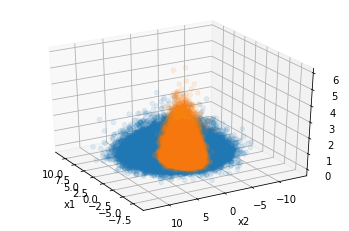

In [154]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b = train['bkg'].numpy()
s = train['sig'].numpy()
ax.scatter(b[:,0], b[:,1], b[:,2], alpha=0.1)
ax.scatter(s[:,0], s[:,1], s[:,2], alpha=0.1)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.view_init(azim=150)



In [0]:
# Validation data
valid = valid_data()
sig_val = tf.data.Dataset.from_tensor_slices(valid['sig'])
bkg_val = tf.data.Dataset.from_tensor_slices(valid['bkg'])

In [0]:
val_set = tf.data.Dataset.zip((sig_val, bkg_val))

## 3. Train the model

In [0]:
k_init = "he_normal"
Dense = k.layers.Dense
par_names = ["s_exp", "r_dist", "b_rate"] #["s_exp"] #, "b_exp"] #["s_exp", "r_dist"]
poi = 's_exp'
pars = list(all_pars.values())
temperature = tf.Variable(1., shape=(), name="temp")
batch_size = 1000 #x2 for signal and bkg
aux = {"r_dist": ds.Normal(loc=2.0, scale=0.4),
       "b_rate": ds.Normal(loc=3.0, scale=1.)}
nn_model = k.Sequential([Dense(units=100, activation="relu",
                                    kernel_initializer=k_init,
                                    input_shape=(3,)),
                         Dense(units=100, activation="relu",
                                    kernel_initializer=k_init),
                              Dense(units=10, activation="linear")])
lr = 10e-6
optimizer = tf.keras.optimizers.Adam(lr)#, clipnorm=1)

In [21]:
pars

[<tf.Variable 's_exp:0' shape=() dtype=float32, numpy=50.0>,
 <tf.Variable 'r_dist:0' shape=() dtype=float32, numpy=2.0>,
 <tf.Variable 'b_rate:0' shape=() dtype=float32, numpy=3.0>,
 <tf.Variable 'b_exp:0' shape=() dtype=float32, numpy=1000.0>]

In [22]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 11,510
Trainable params: 11,510
Non-trainable params: 0
_________________________________________________________________


In [0]:

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [0]:
batched_dataset = dataset.batch(batch_size)

In [0]:
@tf.function
def transform_bkg(x, r_dist_g=2., b_rate_g=3.):

    # apply transformations over each dim
    x_prime_0 = x[:, 0] - r_dist_g + r_dist
    x_prime_1 = x[:, 1]
    x_prime_2 = x[:, 2] * (b_rate_g / b_rate)

    x_prime = tf.stack([x_prime_0, x_prime_1, x_prime_2], 1,
                       name="x_prime")
    return x_prime

In [0]:
@tf.function
def cov_matrix(ext_nll, pars):

    pars = tuple(pars)

    indices = [list(all_pars.keys()).index(par) for par in pars]
    idx_subset = np.reshape(list(it.product(indices, indices)),
                            (len(pars), len(pars), -1))
    #print( idx_subset )

    hess_subset = tf.gather_nd(ext_nll, idx_subset)

    try:
        cov_nll = tf.linalg.inv(hess_subset)
    except:
        print( hess_subset )

    return cov_nll

In [0]:
@tf.function
def conv_hessian(grad_grad, par):

    grad_grad = [tf.zeros_like(pars[j]) if grad is None else grad
                        for j, grad in enumerate(grad_grad)]   
    grad_grad = [tf.expand_dims(g,1) if len(g.shape)==1 else g for g
                        in grad_grad]
    grad_shape = tf.concat([tf.shape(par),[len(pars)]], axis=0)

    return tf.reshape(tf.stack(grad_grad,axis=-1), grad_shape)

In [0]:
@tf.function
def get_counts(batch):

    logits = nn_model(batch)

    probs = tf.nn.softmax(logits / temperature)
    s_probs, b_probs = tf.split(probs, [batch_size,batch_size], axis=0)

    s_counts = tf.reduce_mean(s_probs, axis=0)
    b_counts = tf.reduce_mean(b_probs, axis=0)

    return s_counts, b_counts

In [0]:
@tf.function
def calculate_loss(s_batch, b_batch):

    with tf.GradientTape(persistent=True) as g:

        g.watch(s_exp)
        g.watch(b_exp)
        g.watch(r_dist)
        g.watch(b_rate)

        with tf.GradientTape(persistent=True) as gg:

            gg.watch(s_exp)
            gg.watch(b_exp)
            gg.watch(r_dist)
            gg.watch(b_rate)

            # Transfrom the background to include the nuisance parameters
            b_batch_trf = transform_bkg(b_batch)
            # Pass batch through the neural network to get the predictions for the counts
            train_batch = tf.concat([s_batch, b_batch_trf], axis=0, name="input_batch") 
            s_counts, b_counts = get_counts(train_batch)
            # Scale the predictions by the expected signal and background rates
            exp_counts = tf.cast(s_exp * s_counts + b_exp * b_counts, dtype=tf.float64)

            # Repeat the calculations with stopped gradients to get the asimov variable
            train_batch_const = tf.stop_gradient(train_batch)
            s_counts_asimov, b_counts_asimov = get_counts(train_batch_const)
            s_exp_asimov, b_exp_asimov = tf.stop_gradient(s_exp), tf.stop_gradient(b_exp)
            exp_counts_asimov = tf.cast(s_exp_asimov * s_counts_asimov + b_exp_asimov * b_counts_asimov, dtype=tf.float64)

            if verbose > 0:
                print("Counts")
                print(exp_counts)
                print("Asimov counts")
                print(exp_counts_asimov)

            # Log-likelihood
            pois = ds.Poisson(exp_counts, name="poisson")
            nll = - tf.cast(tf.reduce_sum(pois.log_prob(exp_counts_asimov)), name="nll", dtype=tf.float32)

            # Auxiliary measurements to constrain the nuisances
            nll_aux = {}
            for par, dist in aux.items():
                nll_aux[par] = -dist.log_prob(all_pars[par])
        
        # Gradient of the likelihood
        dy_dx = gg.gradient(nll, pars)
        dy_dx = [tf.zeros_like(pars[j]) if grad is None else grad for j, grad in enumerate(dy_dx)]  

        # Gradient of the auxiliary measurements
        dy_dx_aux = {}
        for par in nll_aux:
            dy_dx_aux_par = gg.gradient(nll_aux[par], pars)
            dy_dx_aux[par] = [tf.zeros_like(pars[j]) if grad is None else grad for j, grad in enumerate(dy_dx_aux_par)] 

    # Hessian of the likelihood
    hess_nll = []
    for i, grad in enumerate(dy_dx):
        grad_grad = g.gradient(grad, pars)
        hess_nll.append(conv_hessian(grad_grad, pars[i]))
    hess_nll = tf.stack(hess_nll, axis=-1)  

    if verbose > 0:
        print("Hessian nll")
        print( hess_nll ) 

    # Hessian of the auxiliary measurements
    hess_nll_aux = {}
    for par in dy_dx_aux:
        hess_nll_aux[par] = []
        for i, grad in enumerate(dy_dx_aux[par]):
            grad_grad = g.gradient(grad, pars)
            hess_nll_aux[par].append(conv_hessian(grad_grad, pars[i]))
        hess_nll_aux[par] = tf.stack(hess_nll_aux[par], axis=-1)  
        if verbose > 0:
            print("Hessian " + par)
            print(hess_nll_aux[par])

    # Extended likelihood
    ext_nll = sum([hess_nll] + list(hess_nll_aux.values()))

    # Covariance matrix
    cov_nll = cov_matrix(ext_nll, par_names)

    if verbose > 0:
        print("Extended likelihood")
        print(ext_nll)
        print("Covariance matrix")
        print(cov_nll)

    idx_poi = par_names.index(poi)
    loss = cov_nll[idx_poi, idx_poi] 

    return loss


In [31]:
verbose = 0
ibatch = 0

train_loss = []
val_loss = []

for epoch in range(100):

    # Check shuffle!! random seed!!
    dataset = dataset.shuffle(10000, reshuffle_each_iteration=True)
    batched_dataset = dataset.batch(batch_size)
    batched_valset = val_set.batch(batch_size)

    for s_batch, b_batch in batched_dataset:#.take(4):

        with tf.GradientTape() as tape:
            loss = calculate_loss(s_batch, b_batch)

        if verbose > 0:
            print("loss")
            print(loss)
        
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', loss, step = ibatch)

        gradients = tape.gradient(loss, nn_model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, nn_model.trainable_variables))

        ibatch += 1
    

    train_loss_epoch = []
    for s_batch, b_batch in batched_dataset:

        loss = calculate_loss(s_batch, b_batch)
        train_loss_epoch.append(loss)

    val_loss_epoch = []
    for s_batch, b_batch in batched_valset:
                
        loss = calculate_loss(s_batch, b_batch)
        val_loss_epoch.append(loss)

    train_loss.append(np.mean(train_loss_epoch))
    val_loss.append(np.mean(val_loss_epoch))

    print("Epoch: ", epoch)
    print("Train loss", train_loss[-1], " -- Val loss", val_loss[-1])

Epoch:  0
Train loss 759.266  -- Val loss 760.40564
Epoch:  1
Train loss 723.9015  -- Val loss 725.0018
Epoch:  2
Train loss 685.9562  -- Val loss 686.37354
Epoch:  3
Train loss 658.66095  -- Val loss 658.9718
Epoch:  4
Train loss 640.65405  -- Val loss 640.65405
Epoch:  5
Train loss 627.2209  -- Val loss 627.10254
Epoch:  6
Train loss 616.5076  -- Val loss 616.2378
Epoch:  7
Train loss 607.3708  -- Val loss 607.44244
Epoch:  8
Train loss 599.9585  -- Val loss 600.0077
Epoch:  9
Train loss 593.254  -- Val loss 593.3932
Epoch:  10
Train loss 587.6471  -- Val loss 587.4085
Epoch:  11
Train loss 581.4765  -- Val loss 581.71295
Epoch:  12
Train loss 575.52405  -- Val loss 575.59106
Epoch:  13
Train loss 567.752  -- Val loss 568.3451
Epoch:  14
Train loss 559.02783  -- Val loss 559.3544
Epoch:  15
Train loss 549.4447  -- Val loss 550.0825
Epoch:  16
Train loss 541.9613  -- Val loss 542.9038
Epoch:  17
Train loss 536.692  -- Val loss 537.48206
Epoch:  18
Train loss 532.5057  -- Val loss 533.

Text(0, 0.5, 'std(s_exp)')

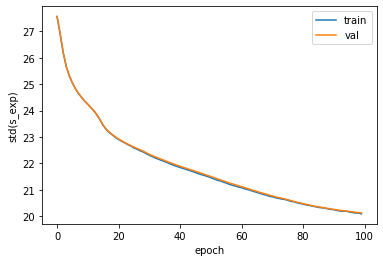

In [35]:
plt.plot(np.sqrt(train_loss))
plt.plot(np.sqrt(val_loss))
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('std(s_exp)')

## Tensorboard 

In [0]:
%tensorboard --logdir logs/gradient_tape

## Random snippets

In [0]:
# Full model
# expected amount of signal
signal_exp = tf.Variable(50., shape=(), name="signal_exp")
# expected amount of background
bkg_exp = tf.Variable(1000., shape=(), name="bkg_exp")

# compute signal fraction from s_exp and b_exp
mu = signal_exp / (signal_exp + bkg_exp)

# full mixture distribution
m_dist = ds.Mixture(cat=ds.Categorical(probs=[1. - mu, mu]),
                            components=[b_dist, s_dist],
                            name="mixture")

b_counts = tf.Variable(
[1.2013696e-02, 3.4166566e-01, 5.8940423e-01, 1.3969673e-03, 1.5554641e-02,
4.4392496e-03, 2.0298790e-03, 3.1998839e-02, 1.3944731e-03, 1.0269688e-04], dtype=tf.float32)
s_counts = tf.Variable(
[1.7830627e-02, 4.5834020e-01, 3.2262495e-01, 5.3610229e-03, 6.8719871e-02,
3.9853200e-02, 6.2792581e-03, 7.6308973e-02, 4.4561680e-03, 2.2559472e-04], dtype=tf.float32)


with tf.GradientTape(persistent = True) as g:
    
    g.watch(signal_exp)
    g.watch(bkg_exp)
    g.watch(b_counts)
    g.watch(s_counts)
    """
    with tf.GradientTape(persistent = True) as gg:
        
        gg.watch(signal_exp)
        gg.watch(bkg_exp)
        gg.watch(b_counts)
        gg.watch(s_counts)

        print(b_counts)
        print(s_counts)
    """
    exp_counts = tf.cast(signal_exp * s_counts + bkg_exp * b_counts, dtype=tf.float64)
    print( "EXPCOUNTS")
    print( exp_counts )

    asimov = tf.stop_gradient(exp_counts, name="asimov")
    print(asimov)  
    print('Sig Asimov')
    print(g.gradient(asimov, signal_exp))       

    pois = ds.Poisson(exp_counts, name="poisson")


    nll = - tf.cast(tf.reduce_sum(pois.log_prob(asimov)),
                        name="nll", dtype=tf.float32)
    #g.watch(nll)
    print('NLL Asimov')
    print(g.gradient(nll, [signal_exp, bkg_exp]))
    
    """
    dy_dx = gg.gradient(nll, [signal_exp, bkg_exp])
    dy_dx = [tf.zeros_like(pars[j]) if grad is None else grad
                      for j, grad in enumerate(dy_dx)]     

    print(dy_dx)

    batch_hessian = hessian(g, dy_dx, [signal_exp, bkg_exp])

    print('hessian Asimov')
    print(g.gradient(batch_hessian[0,0], asimov))
    
    print('Batch hessian')
    print(batch_hessian)

    cov = tf.linalg.inv(batch_hessian)

    print('cov')
    #exp_counts = loss
    #print(tf.matmul(cov, batch_hessian))
    """

#g.gradient(nll, pars)

In [0]:
vals = []
probs = []
for i in range(1000):
    x = tf.random.uniform(shape=[10,], minval=0, maxval=100, dtype=tf.float64)
    vals.append( x.numpy( ))
    probs.append( pois.log_prob(x).numpy() )

In [0]:
vals = np.array(vals)
probs = np.array(probs)

In [0]:
probs.shape

In [0]:
plt.scatter(vals[:,0], probs[:,0])

In [0]:
pois.log_prob(exp_counts).numpy()

In [0]:
v = tf.Variable(tf.random.normal((2,)))
print(v)
with tf.GradientTape(persistent=True) as tape:
    y = tf.sin(v[0] + tf.cos(v[1]))
    print([v])
    grads = tape.gradient(y, [v])
    #print( grads )
    print( grads[0] )
    #print( tape.gradient(y, v) )
    #print
hessians = tape.jacobian(grads[0], v)
#hessians = tape.gradient(grads[0], [v])
print(hessians)

In [0]:
x = tf.random.uniform(shape=[3,2],minval=0, maxval=10) 
y = tf.random.uniform(shape=[3,4],minval=0, maxval=10) 
w1 = tf.Variable(tf.ones([2,3]),dtype=tf.float32 )
w2 = tf.Variable(tf.ones([3,3]), dtype=tf.float32)
w3 = tf.Variable(tf.ones([3,4]), dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam()

with tf.GradientTape() as g:
    
    #g.watch(w1)
    #g.watch(w2)
    #hidden = tf.stop_gradient(tf.matmul(x,w1))
    hidden = tf.matmul(x,w1)
    print(hidden)
    hidden2 = tf.matmul(hidden, w2)
    asimov = tf.stop_gradient(hidden2)
    print(hidden2)
    print(asimov)
    output = tf.matmul(hidden2,w3)
    print(output)
    loss = output - y
    print(loss)

gradients = g.gradient(loss, [w1,w2,w3])
print(gradients)
optimizer.apply_gradients(zip(gradients, [w1,w2,w3])) 
print(w1)
print(w2)
print(w3)